In [67]:
## import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [68]:
print(torch.__version__)

2.8.0+cu126


## Import The Data
The first step before training the model is to import the data. We will use the [MNIST dataset](http://yann.lecun.com/exdb/mnist/) which is like the Hello World dataset of machine learning.

Besides importing the data, we will also do a few more things:
- We will tranform the data into tensors using the `transforms` module
- We will use `DataLoader` to build convenient data loaders or what are referred to as iterators, which makes it easy to efficiently feed data in batches to deep learning models.
- As hinted above, we will also create batches of the data by setting the `batch` parameter inside the data loader. Notice we use batches of `32` in this tutorial but you can change it to `64` if you like. I encourage you to experiment with different batches.

In [69]:
# add google drive access
from google.colab import drive
drive.mount('/content/drive')   # follow the auth link

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [70]:
# create a custom class for the gramian angular fields
from torch.utils.data import Dataset, DataLoader

## transformations
transform = transforms.Compose(
    [transforms.ToTensor()])

class NPZDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        image = self.X[idx]
        label = self.y[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# load the data
data = np.load('/content/drive/MyDrive/training-data/gaf-mtf-training_images_labels.npz', allow_pickle=True)
X = data['X']
X = X.astype('float32')
y = data['y']
class_names = data['class_names']
print(f"shape of images {X.shape}")
print(f"shape of class labels {y.shape}")
print(f"length of class names {class_names.shape}")

shape of images (7848, 40, 40, 12)
shape of class labels (7848,)
length of class names (7848,)


In [71]:
# creat label for object class
label_dict = {90: 'SNIa',
              67: 'SNIa-91bg',
              52: 'SNIax',
              42: 'SNII',
              62: 'SNIbc',
              95: 'SLSN-I',
              15: 'TDE',
              64: 'KN',
              88: 'AGN',
              92: 'RRL',
              65: 'M-dwarf',
              16: 'EB',
              53: 'Mira',
              6: 'mu Lens-Single',
              }


In [72]:
# Convert labels to numpy if needed
y_np = y.cpu().numpy() if isinstance(y, torch.Tensor) else np.asarray(y)

# Use label_dict keys (sorted for reproducibility) as the source of truth
unique_labels = sorted(label_dict.keys())  # preserves stable numeric order
label2idx = {lab: i for i, lab in enumerate(unique_labels)}  # e.g. 6→0, 15→1, …
idx2label = {i: lab for lab, i in label2idx.items()}          # reverse map
num_classes = len(unique_labels)

# Remap y using the fixed mapping
y_mapped_np = np.vectorize(label2idx.get)(y_np)
y = torch.tensor(y_mapped_np, dtype=torch.long)

# Class names aligned to new indices
class_names = [label_dict[idx2label[i]] for i in range(num_classes)]

# ------------------------------------------------------------
# Helper: convert from model’s label index to class name
# ------------------------------------------------------------
def idx_to_classname(idx: int) -> str:
    """Map the *model output index* (0..num_classes-1) to the correct class name."""
    return class_names[idx]

print(class_names)

['mu Lens-Single', 'TDE', 'EB', 'SNII', 'SNIax', 'Mira', 'SNIbc', 'KN', 'M-dwarf', 'SNIa-91bg', 'AGN', 'SNIa', 'RRL', 'SLSN-I']


In [73]:
from torch.utils.data import random_split

BATCH_SIZE = 64
dataset = NPZDataset(X, y, transform=transform)
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
trainset, testset = random_split(dataset, [train_size, test_size])
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [74]:
from sklearn.model_selection import train_test_split
import torch

# If X is numpy: ensure shape (N, C, H, W); if torch: X.numpy() also fine
# y should be a 1D array/tensor of class indices in [0..num_classes-1]

# Convert to numpy if needed (keeps things simple)
X_np = X.cpu().numpy() if isinstance(X, torch.Tensor) else X
y_np = y.cpu().numpy() if isinstance(y, torch.Tensor) else y

X_train, X_test, y_train, y_test = train_test_split(
    X_np, y_np,
    test_size=0.3,
    random_state=42,
    stratify=y_np,        # <- ensures each class appears proportionally in both splits
)

trainset = NPZDataset(X_train, y_train, transform=transform)         # your class
testset  = NPZDataset(X_test,  y_test,  transform=transform)    # (optional) lighter/none

BATCH_SIZE = 64
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)
testloader  = DataLoader(testset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


## Exploring the Data
As a practioner and researcher, I am always spending a bit of time and effort exploring and understanding the dataset. It's fun and this is a good practise to ensure that everything is in order.

torch.Size([12, 40, 40])
Label: 0
(40, 40, 12)


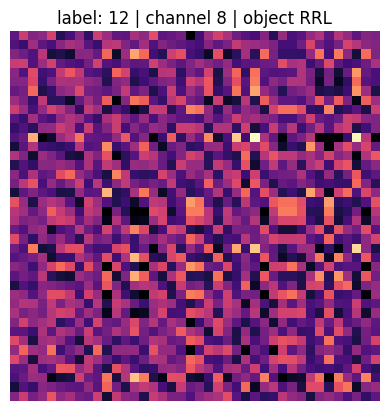

In [75]:
# pick an index
idx = 10
image, label = trainset[idx]
print(image.shape)

print("Label:", y[idx].item())

# if image is in (C, H, W), convert to (H, W, C) for plotting
if image.ndim == 3:
    img_to_show = image.permute(1, 2, 0).numpy()  # channel-last for matplotlib
else:
    img_to_show = image.numpy()
print(img_to_show.shape)

# image: torch.Tensor (C,H,W) = (12,64,64)
ch = 8  # pick channel index
plt.imshow(image[ch].cpu().numpy(), cmap='magma')
plt.title(f'label: {label} | channel {ch} | object {class_names[label]}')
plt.axis('off')
plt.show()

Let's check the dimensions of a batch.

In [76]:
for images, labels in trainloader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    break

Image batch dimensions: torch.Size([64, 12, 40, 40])
Image label dimensions: torch.Size([64])


## The Model
Now using the classical deep learning framework pipeline, let's build the 1 convolutional layer model.

Here are a few notes for those who are beginning with PyTorch:
- The model below consists of an `__init__()` portion which is where you include the layers and components of the neural network. In our model, we have a convolutional layer denoted by `nn.Conv2d(...)`. We are dealing with an image dataset that is in a grayscale so we only need one channel going in, hence `in_channels=1`. We hope to get a nice representation of this layer, so we use `out_channels=32`. Kernel size is 3, and for the rest of parameters we use the default values which you can find [here](https://pytorch.org/docs/stable/nn.html?highlight=conv2d#conv2d).
- We use 2 back to back dense layers or what we refer to as linear transformations to the incoming data. Notice for `d1` I have a dimension which looks like it came out of nowhere. 128 represents the size we want as output and the (`26*26*32`) represents the dimension of the incoming data. If you would like to find out how to calculate those numbers refer to the [PyTorch documentation](https://pytorch.org/docs/stable/nn.html?highlight=linear#conv2d). In short, the convolutional layer transforms the input data into a specific dimension that has to be considered in the linear layer. The same applies for the second linear transformation (`d2`) where the dimension of the output of the previous linear layer was added as `in_features=128`, and `10` is just the size of the output which also corresponds to the number of classes.
- After each one of those layers, we also apply an activation function such as `ReLU`. For prediction purposes, we then apply a `softmax` layer to the last transformation and return the output of that.  

In [90]:
class MyModel(nn.Module):
    def __init__(self, num_classes=10, dropout=0.2):
        super().__init__()
        self.conv1 = nn.Conv2d(12, 32, 3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3   = nn.BatchNorm2d(128)
        self.pool  = nn.MaxPool2d(2,2)
        self.drop2d = nn.Dropout2d(p=0.2)
        self.fc1 = nn.Linear(128*5*5, 256)
        self.drop = nn.Dropout(p=dropout)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.drop2d(x)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.drop2d(x)
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = self.drop(F.relu(self.fc1(x)))
        return self.fc2(x)


As I have done in my previous tutorials, I always encourage to test the model with 1 batch to ensure that the output dimensions are what we expect.

In [91]:
import torch, numpy as np

# labels remapped earlier -> y_mapped
num_classes = int(len(np.unique(y)))

# model on CPU sanity check
model = MyModel(num_classes=num_classes).cpu()
images, labels = next(iter(trainloader))
print('shapes:', images.shape, labels.shape)
print('label range:', labels.min().item(), labels.max().item())

with torch.no_grad():
    logits = model(images.float())
criterion = torch.nn.CrossEntropyLoss()
loss = criterion(logits, labels.long())
print('CPU forward/loss OK')

# now go to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
images = images.to(device).float()
labels = labels.to(device).long()
logits = model(images)
loss = criterion(logits, labels)
loss.backward()
print('GPU step OK')

shapes: torch.Size([64, 12, 40, 40]) torch.Size([64])
label range: 0 13
CPU forward/loss OK
GPU step OK


## Training the Model
Now we are ready to train the model but before that we are going to setup a loss function, an optimizer and a function to compute accuracy of the model.

In [104]:
learning_rate = 0.005
num_epochs = 200
weight_decay = 1e-3

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MyModel(num_classes=num_classes)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay) # ADAM or Stochastic Gradient Descent (SGD)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01, steps_per_epoch=len(trainloader), epochs=num_epochs
)

In [105]:
def get_accuracy(logits, labels):
    """Return fraction correct in [0,1]"""
    preds = torch.argmax(logits, dim=1)
    correct = (preds == labels).sum().item()
    total = labels.size(0)              # actual batch size (handles last small batch)
    return correct / total

Now it's time for training.

In [106]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_correct = 0
    total_samples = 0

    for images, labels in trainloader:
        images = images.to(device).float()
        labels = labels.to(device).long()

        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()  # if using OneCycleLR

        # accumulate sample-accurate stats
        running_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        running_correct += (preds == labels).sum().item()
        total_samples += labels.size(0)

    epoch_loss = running_loss / len(trainloader) if len(trainloader) else 0.0
    epoch_acc = running_correct / total_samples if total_samples else 0.0
    print(f"Epoch: {epoch} | Loss: {epoch_loss:.4f} | Train Accuracy: {epoch_acc*100:.2f}%")


Epoch: 0 | Loss: 2.1213 | Train Accuracy: 28.87%
Epoch: 1 | Loss: 1.9344 | Train Accuracy: 33.84%
Epoch: 2 | Loss: 1.7887 | Train Accuracy: 39.43%
Epoch: 3 | Loss: 1.6600 | Train Accuracy: 43.38%
Epoch: 4 | Loss: 1.5746 | Train Accuracy: 45.66%
Epoch: 5 | Loss: 1.5238 | Train Accuracy: 47.73%
Epoch: 6 | Loss: 1.4796 | Train Accuracy: 48.94%
Epoch: 7 | Loss: 1.4707 | Train Accuracy: 48.21%
Epoch: 8 | Loss: 1.4349 | Train Accuracy: 49.03%
Epoch: 9 | Loss: 1.4154 | Train Accuracy: 49.97%
Epoch: 10 | Loss: 1.3932 | Train Accuracy: 52.18%
Epoch: 11 | Loss: 1.3873 | Train Accuracy: 51.96%
Epoch: 12 | Loss: 1.3461 | Train Accuracy: 52.25%
Epoch: 13 | Loss: 1.3643 | Train Accuracy: 51.72%
Epoch: 14 | Loss: 1.3481 | Train Accuracy: 53.21%
Epoch: 15 | Loss: 1.3454 | Train Accuracy: 52.96%
Epoch: 16 | Loss: 1.3284 | Train Accuracy: 52.85%
Epoch: 17 | Loss: 1.3032 | Train Accuracy: 54.16%
Epoch: 18 | Loss: 1.3216 | Train Accuracy: 53.83%
Epoch: 19 | Loss: 1.2608 | Train Accuracy: 55.40%
Epoch: 20 

We can also compute accuracy on the testing dataset to see how well the model performs on the image classificaiton task. As you can see below, our basic CNN model is performing very well on the MNIST classification task.

In [107]:
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for images, labels in testloader:
        images = images.to(device).float()
        labels = labels.to(device).long()
        logits = model(images)
        preds = torch.argmax(logits, dim=1)
        test_correct += (preds == labels).sum().item()
        test_total += labels.size(0)

test_acc = test_correct / test_total if test_total else 0.0
print(f"Test Accuracy: {test_acc*100:.2f}%")


Test Accuracy: 54.95%


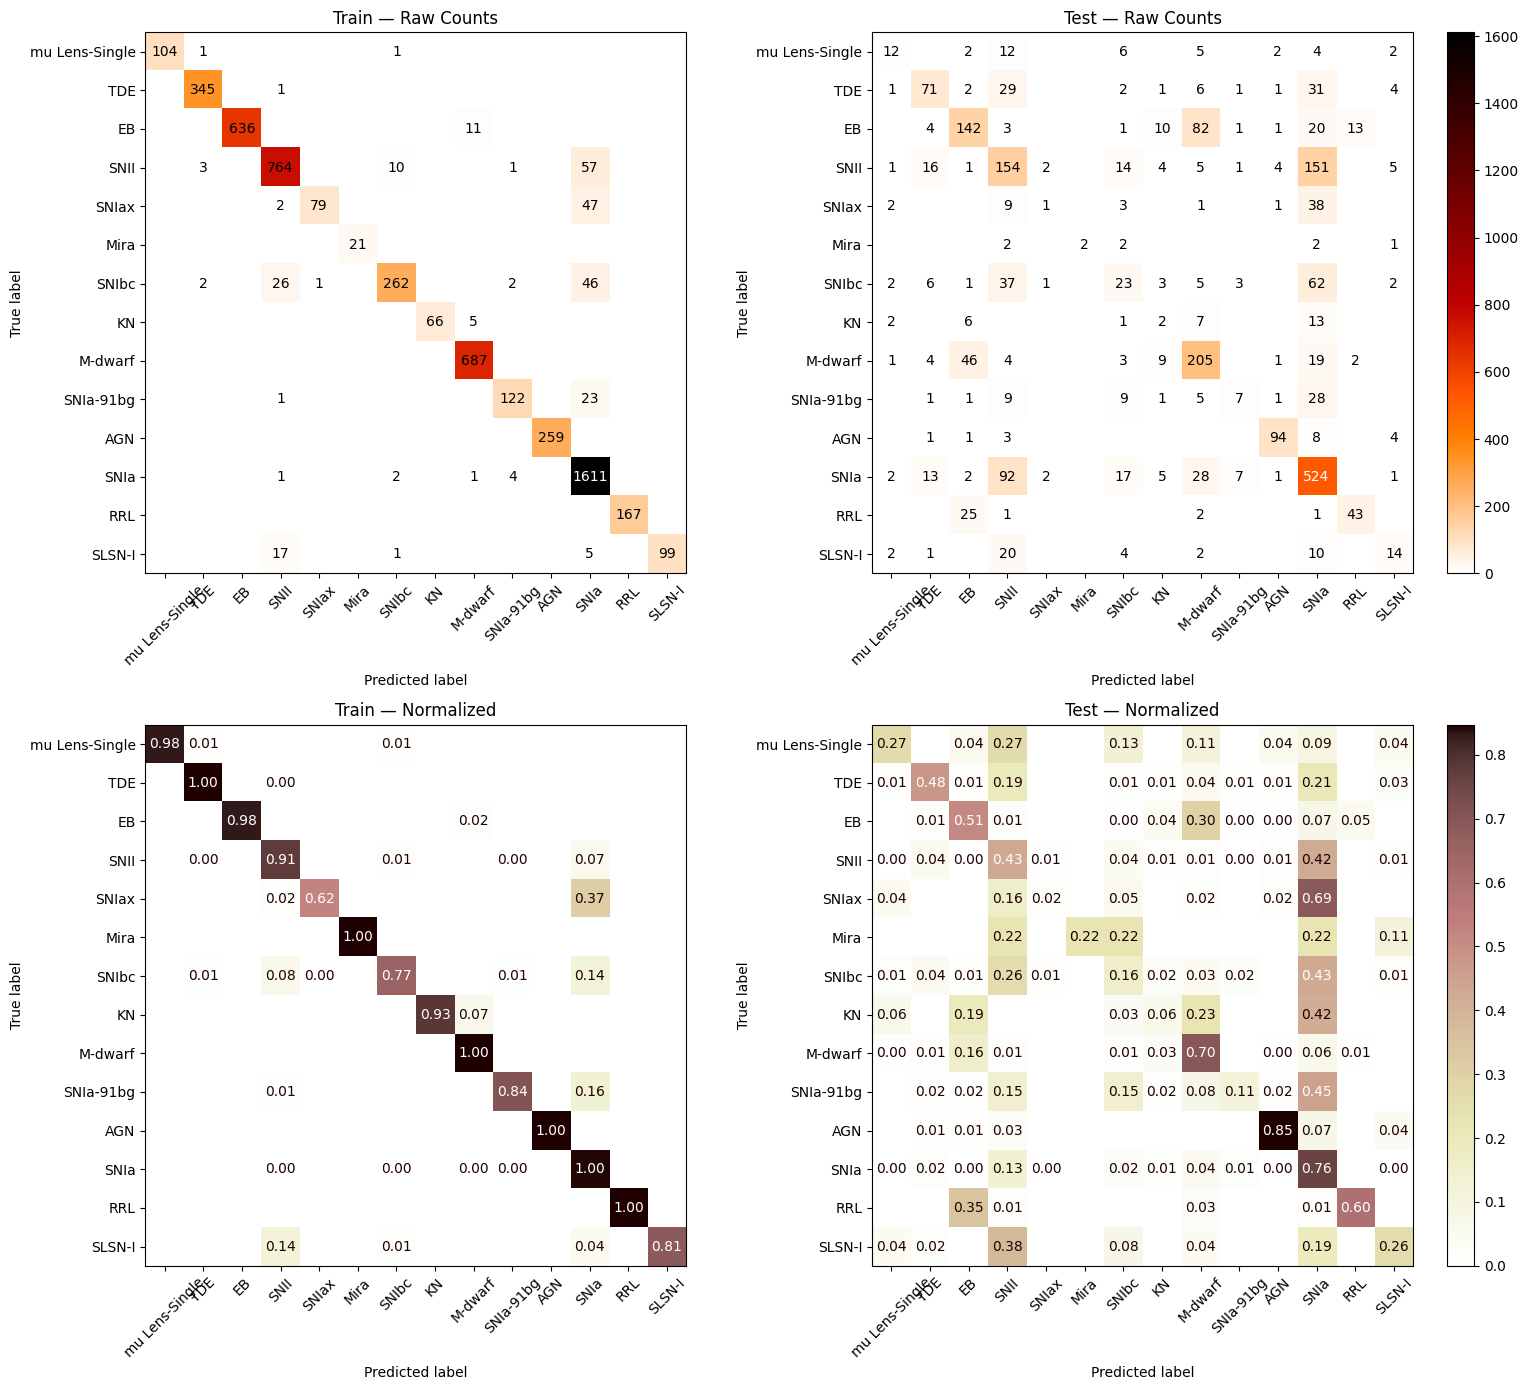

In [108]:
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# --- Collect TEST predictions ---
all_true, all_pred = [], []
model.eval()
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        preds = torch.argmax(logits, dim=1)
        all_true.append(labels.cpu().numpy())
        all_pred.append(preds.cpu().numpy())

y_true_test = np.concatenate(all_true)
y_pred_test = np.concatenate(all_pred)

# --- Collect TRAIN predictions ---
all_true, all_pred = [], []
with torch.no_grad():
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        preds = torch.argmax(logits, dim=1)
        all_true.append(labels.cpu().numpy())
        all_pred.append(preds.cpu().numpy())

y_true_train = np.concatenate(all_true)
y_pred_train = np.concatenate(all_pred)

# --- Confusion Matrices ---
labels_order = list(range(num_classes))
cm_test  = confusion_matrix(y_true_test,  y_pred_test,  labels=labels_order)
cm_train = confusion_matrix(y_true_train, y_pred_train, labels=labels_order)
cm_test_norm  = confusion_matrix(y_true_test,  y_pred_test,  labels=labels_order, normalize="true")
cm_train_norm = confusion_matrix(y_true_train, y_pred_train, labels=labels_order, normalize="true")

# Shared color scale for raw counts
vmax = max(cm_test.max(), cm_train.max())

# --- Two rows: Raw (top, Reds), Normalized (bottom, Blues) ---
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Helper to remove zero texts
def hide_zero_texts(disp, cm):
    """Remove text labels where the confusion matrix value is zero."""
    for (i, j), value in np.ndenumerate(cm):
        if value == 0 and disp.text_[i, j] is not None:
            disp.text_[i, j].set_text("")

# === Row 1: Raw counts (Reds) ===
disp_train = ConfusionMatrixDisplay(cm_train, display_labels=class_names)
disp_train.plot(ax=axes[0, 0], cmap="gist_heat_r", colorbar=False, values_format="d")
axes[0, 0].images[0].set_clim(0, vmax)
axes[0, 0].set_title("Train — Raw Counts")
axes[0, 0].tick_params(axis="x", labelrotation=45)
hide_zero_texts(disp_train, cm_train)

disp_test = ConfusionMatrixDisplay(cm_test, display_labels=class_names)
disp_test.plot(ax=axes[0, 1], cmap="gist_heat_r", colorbar=True, values_format="d")
axes[0, 1].images[0].set_clim(0, vmax)
axes[0, 1].set_title("Test — Raw Counts")
axes[0, 1].tick_params(axis="x", labelrotation=45)
hide_zero_texts(disp_test, cm_test)

# === Row 2: Normalized (Blues) ===
disp_train_norm = ConfusionMatrixDisplay(cm_train_norm, display_labels=class_names)
disp_train_norm.plot(ax=axes[1, 0], cmap="pink_r", colorbar=False, values_format=".2f")
axes[1, 0].set_title("Train — Normalized")
axes[1, 0].tick_params(axis="x", labelrotation=45)
hide_zero_texts(disp_train_norm, cm_train_norm)

disp_test_norm = ConfusionMatrixDisplay(cm_test_norm, display_labels=class_names)
disp_test_norm.plot(ax=axes[1, 1], cmap="pink_r", colorbar=True, values_format=".2f")
axes[1, 1].set_title("Test — Normalized")
axes[1, 1].tick_params(axis="x", labelrotation=45)
hide_zero_texts(disp_test_norm, cm_test_norm)

plt.tight_layout()
plt.show()
